In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import distributions
from eofs.xarray import Eof

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

In [3]:
# functions to compute various NRMSEs
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [4]:
# computes t-test for differences
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

In [5]:
# compute vpd, given relative humidity and temperature
def get_vpd(humidity_data, tas_data):
    svp = 0.6112 * np.exp(17.76*(tas_data-273)/((tas_data-273) + 243.5))
    vpd = svp * (1 - humidity_data/100)
    return vpd

In [6]:
train_scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585', 'hist-aer', 'hist-GHG']

In [7]:
Xtrain = xr.concat(
    [xr.open_dataset(f'train_val/inputs_{s}.nc') for s in train_scenarios]
    , dim='time')

In [8]:
# load and compute VPD for train and test data
hursTrain = xr.concat([xr.open_dataset(f'vpd_data/hurs_{s}.nc') for s in train_scenarios]
    , dim='time')
tasTrain = xr.concat([xr.open_dataset(f'vpd_data/tas_{s}.nc') for s in train_scenarios]
    , dim='time')
vpdTrain = get_vpd(hursTrain.hurs, tasTrain.tas).to_dataset(name='vpd')

hursTest = xr.open_dataset('vpd_data/hurs_ssp245.nc')
tasTest = xr.open_dataset('vpd_data/tas_ssp245.nc')
vpdTest = get_vpd(hursTest.hurs, tasTest.tas).to_dataset(name='vpd')

In [9]:
# add year data to X and Y
Xtrain["time"]=np.arange(1, 754)
vpdTrain["time"]=np.arange(1, 754)

In [10]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
bc_solver = Eof(Xtrain['BC'])
so2_solver = Eof(Xtrain['SO2'])

In [11]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
bc_eofs = bc_solver.eofsAsCorrelation(neofs=5)
bc_pcs = bc_solver.pcs(npcs=5, pcscaling=1)

so2_eofs = so2_solver.eofsAsCorrelation(neofs=5)
so2_pcs = so2_solver.pcs(npcs=5, pcscaling=1)

In [12]:
# Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
bc_df = bc_pcs.to_dataframe().unstack('mode')
bc_df.columns = [f"BC_{i}" for i in range(5)]

so2_df = so2_pcs.to_dataframe().unstack('mode')
so2_df.columns = [f"SO2_{i}" for i in range(5)]

In [13]:
# Bring the emissions data back together again and normalize
leading_historical_inputs = pd.DataFrame({
    "CO2": normalize_co2(Xtrain["CO2"].data),
    "CH4": normalize_ch4(Xtrain["CH4"].data)
}, index=Xtrain["CO2"].coords['time'].data)


In [14]:
# format Xtrain and ytrain to be used for random forest model
Xinput = pd.concat([leading_historical_inputs, bc_df, so2_df], axis=1).to_numpy()

In [15]:
Yinput = vpdTrain['vpd'].stack(dim=['lat','lon']).to_numpy()

In [16]:
# taken verbatim from Original_RF_model.ipynb
# parameters & hyperparameters for model

# Number of trees in random forest
n_estimators = [600, 800, 1000, 1200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [37, 45, 53]
# Minimum number of samples required to split a node
min_samples_split = [25, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [17]:
# dictionary to hold all 4 random forest models
random_forest_regressor = RandomForestRegressor(random_state=0)

# create rscvs for each model
RSCV = RandomizedSearchCV(
        estimator = random_forest_regressor, 
        param_distributions = random_grid, 
        n_iter = 29, 
        cv = 3, 
        verbose=2, 
        n_jobs = -1
    )

# create random forests
random_forest = RSCV.fit(Xinput, Yinput)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=True, max_depth=45, max_features=sqrt, min_samples_leaf=6, min_samples_split=30, n_estimators=600; total time= 1.9min
[CV] END bootstrap=True, max_depth=45, max_features=sqrt, min_samples_leaf=6, min_samples_split=30, n_estimators=600; total time= 1.8min


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=53, max_features=sqrt, min_samples_leaf=8, min_samples_split=30, n_estimators=1200; total time= 3.6min
[CV] END bootstrap=True, max_depth=45, max_features=sqrt, min_samples_leaf=6, min_samples_split=30, n_estimators=600; total time= 2.0min
[CV] END bootstrap=True, max_depth=53, max_features=sqrt, min_samples_leaf=8, min_samples_split=30, n_estimators=1200; total time= 3.7min
[CV] END bootstrap=True, max_depth=45, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=800; total time= 2.5min
[CV] END bootstrap=True, max_depth=53, max_features=sqrt, min_samples_leaf=8, min_samples_split=30, n_estimators=1200; total time= 4.1min
[CV] END bootstrap=True, max_depth=45, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=800; total time= 2.8min
[CV] END bootstrap=True, max_depth=53, max_features=auto, min_samples_leaf=6, min_samples_split=25, n_estimators=800; total time= 5.4min
[CV] END bootstrap=True, max_depth=53,

In [18]:
print(random_forest.best_params_)

{'n_estimators': 600, 'min_samples_split': 30, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 37, 'bootstrap': True}


In [19]:
# load test data
Xtest = xr.open_dataset('test/inputs_ssp245.nc')
hursTest = xr.open_dataset('vpd_data/hurs_ssp245.nc')
tasTest = xr.open_dataset('vpd_data/tas_ssp245.nc')
vpdTest = get_vpd(hursTest.hurs, tasTest.tas).to_dataset(name='vpd')

In [20]:
# process aerosol data for test inputs
bc_test = (bc_solver.projectField(Xtest["BC"], neofs=5, eofscaling=1)
           .to_dataframe()
           .unstack('mode')
           .rename(columns={i:f"BC_{i}" for i in range(5)}))

so_test = (so2_solver
           .projectField(Xtest["SO2"], neofs=5, eofscaling=1)
           .to_dataframe()
           .unstack('mode')
           .rename(columns={i:f"_{i}" for i in range(5)}))

In [21]:
test_inputs = pd.DataFrame({
    "CO2": normalize_co2(Xtest["CO2"].data),
    "CH4": normalize_ch4(Xtest["CH4"].data)
}, index=Xtest["CO2"].coords['time'].data)

test_inputs=pd.concat([test_inputs, bc_test, so_test], axis=1)

In [22]:
# get predictions on test data
output = random_forest.predict(test_inputs).reshape(86,96,144)

In [23]:
nrmses = [[
        get_nrmse_spatial(vpdTest['vpd'], output), 
        get_nrmse_global(vpdTest['vpd'], output),
        get_nrmse(vpdTest['vpd'], output)
]]

nrmse_table = pd.DataFrame(data=nrmses, index=['vpd'], columns=['spatial', 'global', 'total']).round(3)
nrmse_table

,spatial,global,total
vpd,0.117,0.063,0.432


In [24]:
# turn output into dataarray to plot
xr_output=xr.Dataset(
    coords={'time': vpdTest.time.values, 'lat': vpdTest.lat.values, 'lon': vpdTest.lon.values})

xr_output['vpd'] = (['time', 'lat', 'lon'], output)

In [25]:
# san diego location is (lat = 32.7W, lon = 117.6N)
sd_lat = xr_output.lat[65]
sd_lon = xr_output.lon[97] # 360-117.6
sd_lat.data, sd_lon.data

(array(33.15789474), array(242.5))

In [26]:
# function to get VPD from 2080-2100 in San Diego
def get_sd_VPD(vpd_data):
    return vpd_data.loc[dict(lat=sd_lat,lon=sd_lon)].sel(time=slice(2080,2100))['vpd'].data

In [27]:
# get predictions and actual VPD at San Diego
sd_pred = get_sd_VPD(xr_output)
sd_actual = get_sd_VPD(vpdTest)

In [28]:
# years for looking at San Diego VPD
years = list(range(2080,2101))

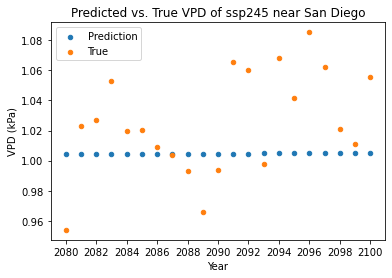

In [29]:
# create scatter plot
plt.scatter(years,sd_pred,s=20,label='Prediction')
plt.scatter(years,sd_actual,s=20,label='True')
plt.xticks(list(range(2080,2101,2)))
plt.xlabel('Year')
plt.ylabel('VPD (kPa)')
plt.title('Predicted vs. True VPD of ssp245 near San Diego')
plt.legend();

In [30]:
# variables used in plotting
p_level = 0.05
proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-4, vmax=4), dict(vmin=-4, vmax=4), dict(vmin=-0.2, vmax=0.2)]
titles = ['Predicted', 'True', 'Differences']

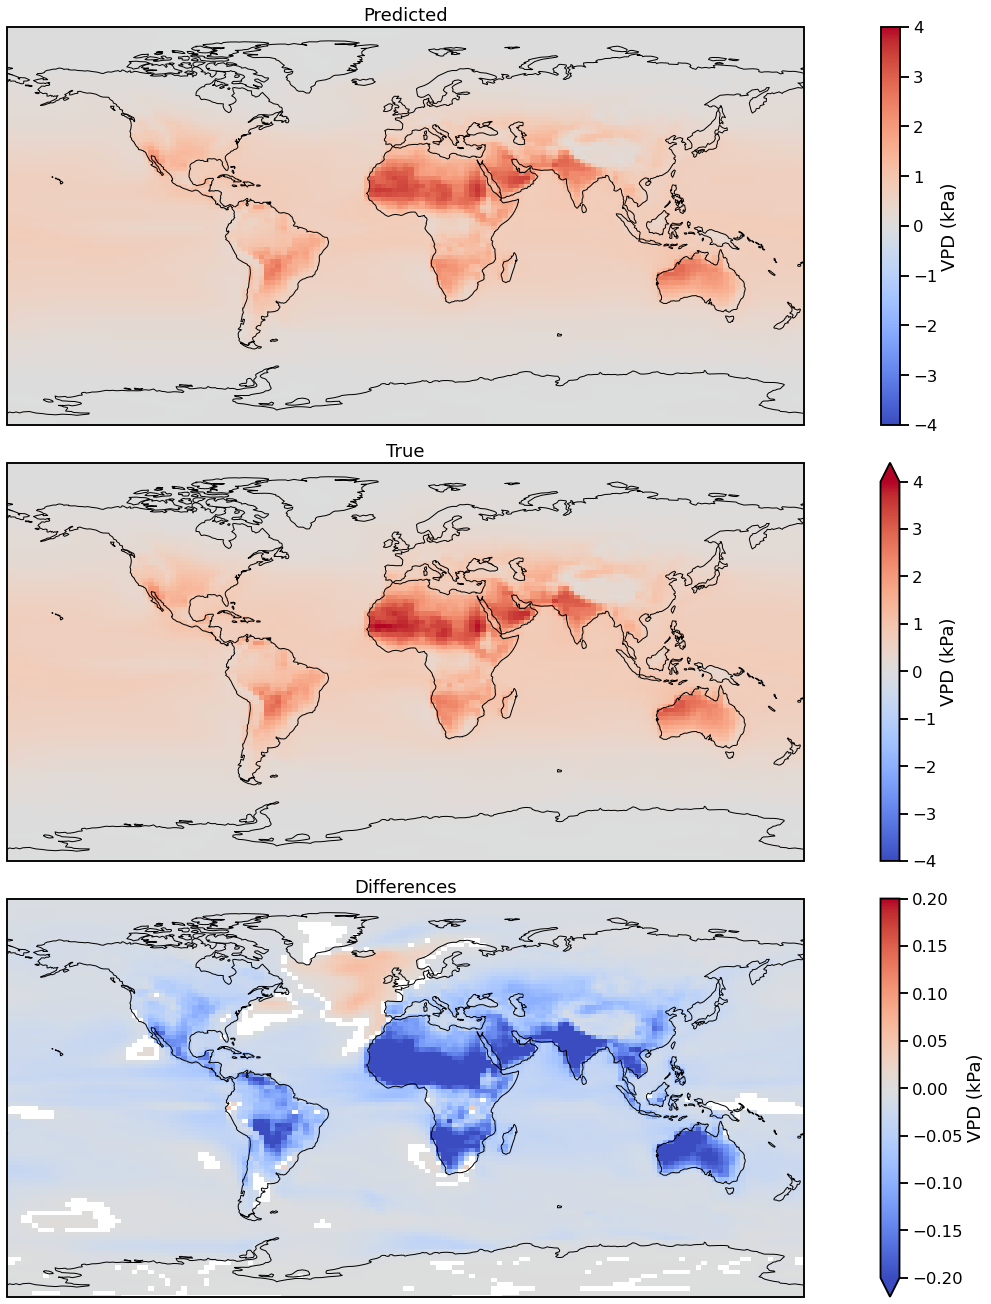

In [31]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(3, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    diff = xr_output - vpdTest
    plot_data = [xr_output, vpdTest, diff]
    for i in range(3):
        ax = axes[i]
        data = plot_data[i]['vpd'][-21:]
        kws = kwargs[i]
        title = titles[i]
        
        ax.set_title(title)
        mean_time = data.mean('time')
        # only show regions with statistically significant difference
        # when plotting differences
        if i == 2:
            _, p = ttest_rel_from_stats(mean_time, data.std('time'), data.count('time'))
            mean_time = mean_time.where(p<p_level)
        
        (mean_time.plot(
                     cmap="coolwarm", 
                     ax=ax, 
                     add_labels=False, 
                     transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"label":"VPD (kPa)", "orientation":'vertical'},
                     **kws))
        ax.coastlines()